## Imports and Data Loading

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import scipy

In [19]:
# load data
hr = pd.read_csv('data/alpaca_hr.csv')
resp = pd.read_csv('data/alpaca_resp.csv')
sao2 = pd.read_csv('data/alpaca_sao2.csv')

hr['offset'] = hr['offset'] / 60
resp['offset'] = resp['offset'] / 60
sao2['offset'] = sao2['offset'] / 60

gcs = pd.read_csv('data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['observationoffset'] = gcs['observationoffset'] / 60
final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']

final_gcs = gcs[final_gcs_id]
display(final_gcs)

#display(hr)
#display(resp)
#display(sao2)

,patientunitstayid,observationoffset,Key,Value,origin
0,172448,2.500000,Motor,1.0,nurse_charting
31,242714,46.850000,Motor,6.0,nurse_charting
40,242825,12.733333,Motor,6.0,nurse_charting
45,243176,54.566667,Motor,6.0,nurse_charting
86,243493,59.033333,Motor,6.0,nurse_charting
...,...,...,...,...,...
135846,3351268,187.383333,Motor,6.0,nurse_charting
135847,3351533,29.583333,Motor,6.0,nurse_charting
135858,3351909,156.950000,Motor,6.0,nurse_charting
135900,3352618,346.600000,Motor,6.0,nurse_charting


In [21]:
# NOTE: Need to do this SEPARATELY for train/val/test
# deal with nan
interplim = 1000
hr = hr.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
resp = resp.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
sao2 = sao2.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))

#for now drop Nan rows (shouldn't be many)...
hr = hr.dropna()
resp = resp.dropna()
sao2 = sao2.dropna()

display(hr.loc[hr['patientunitstayid'] == 143274])

,patientunitstayid,offset,value
12,143274,1.016667,95.0
13,143274,1.100000,97.0
14,143274,1.183333,97.0
15,143274,1.266667,98.0
16,143274,1.350000,98.0
...,...,...,...
566,143274,47.183333,103.0
567,143274,47.266667,112.0
568,143274,47.350000,109.0
569,143274,47.433333,142.0


## Set Parameters

In [4]:
# prediction frequency refers to the frequency with which we want to predict GCS
prediction_freq = 2

# summarization interval refers to the spacing between edges of the bins of our histogram (for summarizing physiology)
summarization_int = 0.25

## Bin data

In [5]:
# split data into bins based on summarization_int
bins=np.arange(1000, step=summarization_int)
hr['offset_bin'] = pd.cut(hr['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
#display(hr[hr['patientunitstayid'] == 318676])
hr_grouped = hr.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#hr_grouped['patientunitstayid'] = hr_grouped['patientunitstayid'].astype(int)

resp['offset_bin'] = pd.cut(resp['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
resp_grouped = resp.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#resp_grouped['patientunitstayid'] = resp_grouped['patientunitstayid'].astype(int)

sao2['offset_bin'] = pd.cut(sao2['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
sao2_grouped = sao2.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#sao2_grouped['patientunitstayid'] = sao2_grouped['patientunitstayid'].astype(int)

gcs['offset_bin'] = pd.cut(gcs['observationoffset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
gcs_grouped = gcs.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#gcs_grouped['patientunitstayid'] = gcs_grouped['patientunitstayid'].astype(int)

## Plot Samples

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


Text(0.5, 1.0, 'Motor GCS')

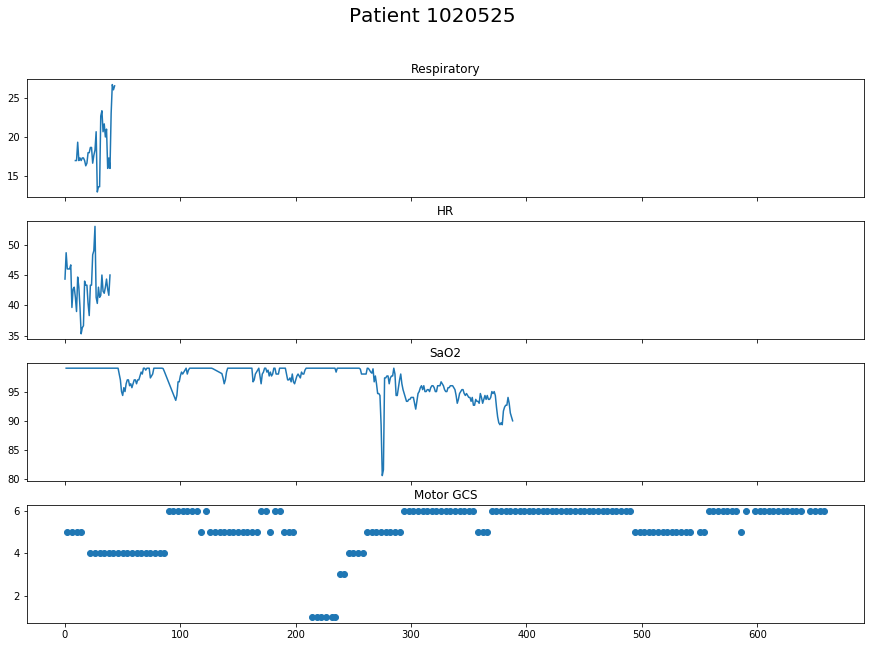

In [6]:
# get one patient's data
ind_slice = np.argwhere(hr_grouped['patientunitstayid'] == 1020525).flatten()
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,10))
f.suptitle("Patient 1020525", size = 20)
ax1.plot(np.arange(resp_grouped[resp_grouped.index.isin(ind_slice)]['value'].shape[0]),
         resp_grouped[resp_grouped.index.isin(ind_slice)]['value'])
ax1.set_title("Respiratory")

ax2.plot(np.arange(hr_grouped[hr_grouped.index.isin(ind_slice)]['value'].shape[0]),
         hr_grouped[hr_grouped.index.isin(ind_slice)]['value'])
ax2.set_title("HR")

ax3.plot(np.arange(sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'].shape[0]),
         sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'])
ax3.set_title("SaO2")

ax4.scatter(gcs_grouped[gcs_grouped.index.isin(ind_slice)]['offset_bin'], gcs_grouped[gcs_grouped.index.isin(ind_slice)]['Value'])
ax4.set_title("Motor GCS")

## Modeling

In [199]:
# interpolate signal
hr_first24 = hr_grouped.copy()
resp_first24 = resp_grouped.copy()
sao2_first24 = sao2_grouped.copy()

hr_first24['value'] = hr_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
resp_first24['value'] = resp_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
sao2_first24['value'] = sao2_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']

In [200]:
# get first 24 hrs
hr_first24 = hr_first24.loc[hr_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])
resp_first24 = resp_first24.loc[resp_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])
sao2_first24 = sao2_first24.loc[sao2_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])

# fill remaining na fields (beginning of patient stay if any) with overall signal mean (maybe median itf?)
hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.mean()))
resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.mean()))
sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.mean()))

#display(resp_first24)
#display(sao2_first24)

,patientunitstayid,value
0,143274,NaN
1,143274,NaN
2,143274,NaN
3,143274,NaN
3999,144116,NaN
...,...,...
12025025,3352618,NaN
12025026,3352618,NaN
12025027,3352618,NaN
12025028,3352618,NaN


In [208]:
further_exclusion = hr_first24.loc[hr_first24.isna()['value']]['patientunitstayid'].unique()
further_exclusion = np.hstack([further_exclusion, resp_first24.loc[resp_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, sao2_first24.loc[sao2_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.unique(further_exclusion)
print(further_exclusion.shape)

(76,)


In [209]:
# organize by patient

# first grab all the patient ids

# ISSUE: some patients are not represented, need to think of how to include them, perhaps -1?
keys1, keys2, keys3, keys4 = hr['patientunitstayid'].unique(), resp['patientunitstayid'].unique(), sao2['patientunitstayid'].unique(), final_gcs['patientunitstayid'].unique()
keys = []
for k in keys1:
    if (k in keys2) and (k in keys3) and (k in keys4) and (k not in further_exclusion):
        keys.append(k)

# now stack data based on the same patient order
X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

In [210]:
# naive model (stack 96x3 features and train classifier)
X_combined = np.vstack([X_hr, X_resp, X_sao2])
target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
        None] for g in keys])

In [218]:
trainX, testX, trainY, testY = train_test_split(X_combined.T, target_gcs, test_size=0.4)
print(trainX.shape, testX.shape)

(1395, 288) (931, 288)


In [219]:
# train model
clf = LogisticRegression()
clf.fit(trainX, trainY)

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [231]:
# test model
predY = clf.predict(testX)
display(testY[(predY != testY)[:, 0]])

array([[5.],
       [5.],
       [5.],
       [5.],
       [4.],
       [5.],
       [4.],
       [4.],
       [5.],
       [1.],
       [4.],
       [5.],
       [5.],
       [5.],
       [1.],
       [4.],
       [1.],
       [5.],
       [5.],
       [5.],
       [1.],
       [5.],
       [1.],
       [4.],
       [1.],
       [1.],
       [5.],
       [1.],
       [1.],
       [1.],
       [1.],
       [5.],
       [5.],
       [5.],
       [1.],
       [2.],
       [1.],
       [3.],
       [5.],
       [1.],
       [5.],
       [1.],
       [2.],
       [3.],
       [5.],
       [5.],
       [5.],
       [3.],
       [4.],
       [4.],
       [4.],
       [1.],
       [2.],
       [4.],
       [2.],
       [5.],
       [1.],
       [5.],
       [2.],
       [1.],
       [1.],
       [4.],
       [1.],
       [1.],
       [1.],
       [4.],
       [2.],
       [4.],
       [1.],
       [1.],
       [5.],
       [4.],
       [1.],
       [1.],
       [1.],
       [5.],
       [4.],